# Assignment: Прогнозирование уровня средней заработной платы в России
В файле записаны данные о заработной плате за каждый месяц с января 1993 по август 2016.

Необходимо проанализировать данные, подобрать для них оптимальную прогнозирующую модель в классе ARIMA и построить прогноз на каждый месяц на два года вперёд от конца данных.

Придерживайтесь стандартного алгоритма построения прогноза:

- Визуальный анализ ряда

- Стабилизация дисперсии (при необходимости)

- Выбор порядка дифференцирования

- Выбор начальных приближений для p,q,P,Q.

- Обучение и сравнение моделей-кандидатов, выбор победителя

- Анализ остатков построенной модели, при необходимости — её модификация: если остатки получаются смещёнными, прогноз нужно скорректировать на константу; если остатки нестационарны или автокоррелированы, можно попробовать расширить область, в которой подбираются значения p,q,P,Q.

- Прогнозирование с помощью финальной модели.

In [197]:
!pip install statsmodels==0.13.1

In [198]:
import pandas as pd
import numpy as np

from itertools import product
from scipy import stats

import statsmodels.api as sm
import matplotlib.pyplot as plt
%matplotlib inline

def invboxcox(y, lmbda):
   if lmbda == 0:
      return np.exp(y)
   else:
      return np.exp(np.log(lmbda*y+1)/lmbda)


import warnings
warnings.filterwarnings("ignore")

In [199]:
data = pd.read_csv('WAG_C_M.csv', sep=';', index_col=['month'], parse_dates=['month'], dayfirst=True)
data

WAG_C_M 
 
 
 month 
 
 
 
 
 
 1993-01-01 
 15.3 
 
 
 1993-02-01 
 19.1 
 
 
 1993-03-01 
 23.6 
 
 
 1993-04-01 
 30.6 
 
 
 1993-05-01 
 37.5 
 
 
 ... 
 ... 
 
 
 2016-04-01 
 36497.0 
 
 
 2016-05-01 
 37270.0 
 
 
 2016-06-01 
 38447.0 
 
 
 2016-07-01 
 35888.0 
 
 
 2016-08-01 
 34095.0 
 
 
 
 284 rows × 1 columns

In [200]:
data.describe()

WAG_C_M 
 
 
 
 
 count 
 284.000000 
 
 
 mean 
 12193.308099 
 
 
 std 
 11992.326701 
 
 
 min 
 15.300000 
 
 
 25% 
 1191.000000 
 
 
 50% 
 7195.000000 
 
 
 75% 
 21365.250000 
 
 
 max 
 43408.000000

### Task 1. Визуальный анализ ряда

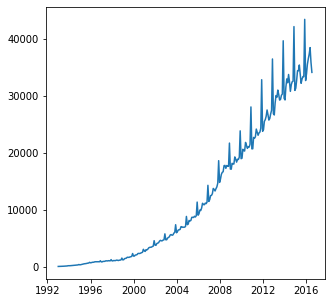

In [201]:
pic = plt.figure(1, figsize=(5,5))
pic = plt.plot(data.index, data['WAG_C_M'])

Видим выраженный повышающийся тренд (плавное долгосрочное изменение уровня ряда вверх) и сезонность в данных: значение признака совершает колебания, причем делают это с возрастанием в амплитуде. В силу увеличения амплитуды колебаний можно сделать вывод, что дисперсия не стабильна - исправим это.

*P.S.* Убедимся формально в нестационарности ряда с помощью критерия Дики-Фуллера:

In [202]:
sm.tsa.stattools.adfuller(data['WAG_C_M'])

(0.8134112642935677,
 0.9918495954854735,
 14,
 269,
 {'1%': -3.4548957220044336,
  '5%': -2.8723451788613157,
  '10%': -2.572527778361272},
 3861.7644347401174)

### Task 2. Стабилизация дисперсии

При работе с нестационарными временными рядами используется ряд стандартных трюков, чтобы сделать
их стационарными. В случае, если во временном ряде монотонно по времени изменяется дисперсия, применяется специальное преобразование, стабилизирующее дисперсию. Воспользуемся преобразованием Бокса-Кокса:

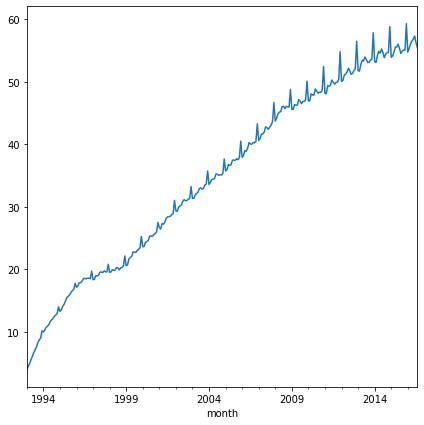

In [203]:
plt.rcParams["figure.figsize"] = (7,7)
data['box_cox'], lmbda = stats.boxcox(data.WAG_C_M)
data.box_cox.plot()

In [204]:
sm.tsa.stattools.adfuller(data['box_cox'])

(-1.144753947887601,
 0.6968987634832757,
 13,
 270,
 {'1%': -3.4548039258751206,
  '5%': -2.872304928618605,
  '10%': -2.5725063100137175},
 -16.017167830688777)

Видим, что ситуация с дисперсией стала получше и критерий Дики-Фуллера понизился.

### Task 3. Выбор порядка дифференцирования

Продифференцируем сезонно для начала:

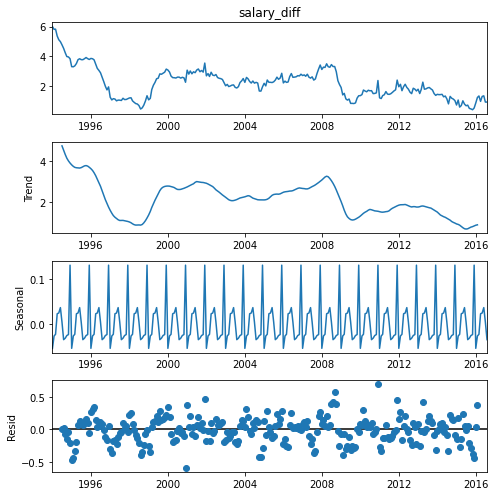

In [205]:
data['salary_diff'] = data.box_cox - data.box_cox.shift(12)

sm.tsa.seasonal_decompose(data.salary_diff[12:]).plot()
sm.tsa.stattools.adfuller(data.salary_diff[12:])

Все еще не стационарен, сделаем теперь обычное дифференцирование:

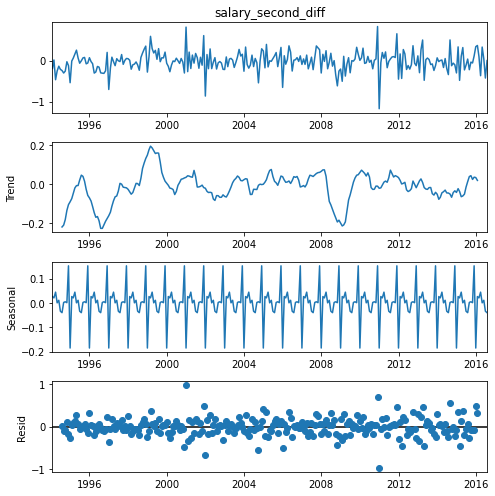

In [206]:
data['salary_second_diff'] = data.salary_diff - data.salary_diff.shift(1)

sm.tsa.seasonal_decompose(data.salary_second_diff[13:]).plot()
sm.tsa.stattools.adfuller(data.salary_second_diff[13:])

Теперь значение критерия Дики-Фуллера достаточно мало, чтобы признать ряд стационарным.

### Task 4. Выбор начальных приближений p, q, P, Q.

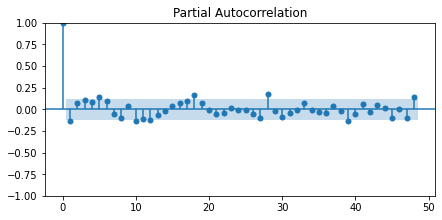

In [207]:
pic = plt.subplot(211)
sm.graphics.tsa.plot_acf(data.salary_second_diff[13:].values.squeeze(), lags=48, ax=pic)
plt.show()

pic = plt.subplot(212)
sm.graphics.tsa.plot_pacf(data.salary_second_diff[13:].values.squeeze(), lags=48, ax=pic)
plt.show()

Из полученного графика автокорреляции можно сделать вывод, что Q = 0, q = 1.

Из полученного графика частичной автокорреляции можно сделать вывод, что P = 1, p = 18.

In [208]:
ps = range(0, 19)
d=1
qs = range(0, 2)
Ps = range(0, 2)
D=1
Qs = range(0, 1)

In [209]:
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

76

### Task 5. Обучение и сравнение моделей-кандидатов, выбор победителя

In [210]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(data.box_cox, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

wrong parameters: (12, 0, 1, 0)
wrong parameters: (12, 1, 1, 0)
wrong parameters: (13, 0, 1, 0)
wrong parameters: (13, 1, 1, 0)
wrong parameters: (14, 0, 1, 0)
wrong parameters: (14, 1, 1, 0)
wrong parameters: (15, 0, 1, 0)
wrong parameters: (15, 1, 1, 0)
wrong parameters: (16, 0, 1, 0)
wrong parameters: (16, 1, 1, 0)
wrong parameters: (17, 0, 1, 0)
wrong parameters: (17, 1, 1, 0)
wrong parameters: (18, 0, 1, 0)
wrong parameters: (18, 1, 1, 0)
CPU times: user 1min 4s, sys: 20 s, total: 1min 24s
Wall time: 42.3 s


In [211]:
warnings.filterwarnings("ignore")
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

       parameters       aic
45  (11, 0, 1, 0) -9.662085
47  (11, 1, 1, 0) -9.509328
60  (18, 0, 0, 0) -8.464590
61  (18, 1, 0, 0) -7.687090
25   (6, 0, 1, 0) -7.552970


/opt/python/envs/default/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [212]:
# Лучшая модель:
print(best_model.summary())

                                      SARIMAX Results                                      
Dep. Variable:                             box_cox   No. Observations:                  284
Model:             SARIMAX(11, 1, 0)x(1, 1, 0, 12)   Log Likelihood                  17.831
Date:                             Tue, 18 Jan 2022   AIC                             -9.662
Time:                                     18:18:14   BIC                             37.165
Sample:                                 01-01-1993   HQIC                             9.140
                                      - 08-01-2016                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2176      0.048     -4.566      0.000      -0.311      -0.124
ar.L2          0.0205      

### Task 6. Анализ остатков построенной модели, при необходимости — её модификация:

Если остатки получаются смещёнными, прогноз нужно скорректировать на константу; если остатки нестационарны или автокоррелированы, можно попробовать расширить область, в которой подбираются значения p,q,P,Q.

Критерий Стьюдента: p=0.131488
Критерий Дики-Фуллера: p=0.000000


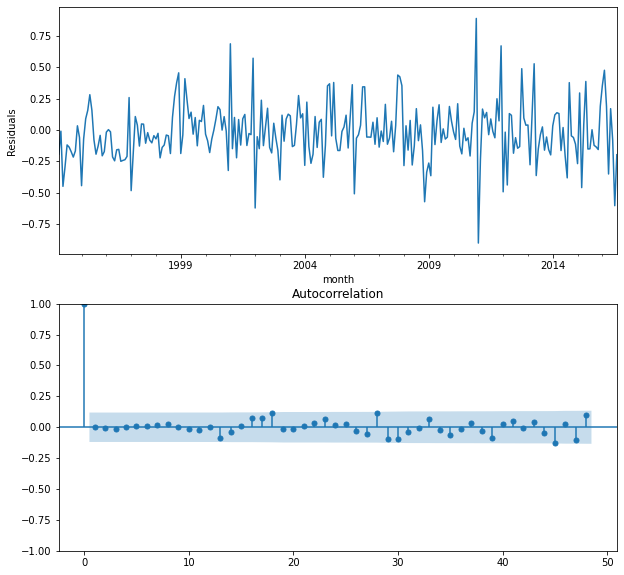

In [213]:
plt.rcParams["figure.figsize"] = (10,10)
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[13:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

Остатки несмещены (подтверждается критерием Стьюдента) стационарны (подтверждается критерием Дики-Фуллера и визуально), неавтокоррелированы (подтверждается критерием Льюнга-Бокса и коррелограммой).

### Task 7. Прогнозирование с помощью финальной модели.

Смотрим, насколько хорошо модель описывает данные:

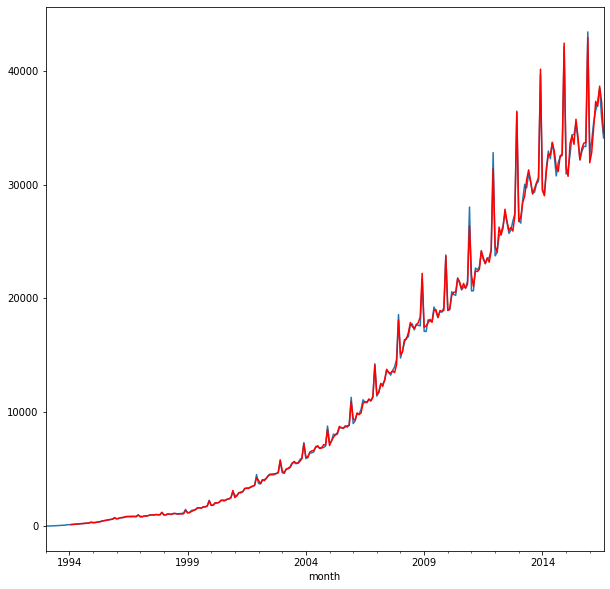

In [214]:
data['model'] = invboxcox(best_model.fittedvalues, lmbda)
plt.rcParams["figure.figsize"] = (10,10)
data.WAG_C_M.plot()
data.model[13:].plot(color='r')

В целом, модель достаточно хорошо описывает данные. Теперь сделаем прогноз:

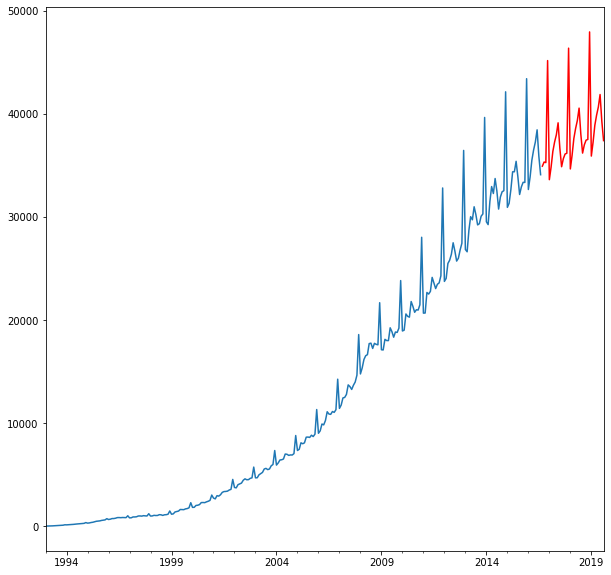

In [218]:
from datetime import datetime
import datetime
from dateutil.relativedelta import *
salary = data[['WAG_C_M']]

date_list = [datetime.datetime.strptime("2016-09-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0,36)]
future = pd.DataFrame(index=date_list, columns=salary.columns)

salary = pd.concat([salary, future])
salary['forecast'] = invboxcox(best_model.predict(start=284, end=325), lmbda)

salary.WAG_C_M.plot()
salary.forecast.plot(color='r')
plt.show()